# Esempio di codifica per il corso di Intelligenza Artifciale

Di seguito sono mostrati alcuni esempi di implementazione della **Search in python**.

Gli esempi sono stati liberamente ispirati dal libro *Artificial Intelligence: A Modern Approach.*

In [12]:
from IPython import get_ipython
get_ipython().run_line_magic('matplotlib', 'inline')
%matplotlib inline
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib import lines

from ipywidgets import interact
import ipywidgets as widgets
from IPython.display import display
import time

import search as s

**Dichiarazione delle strutture dati delle mappe**

In [13]:
romania_map = s.UndirectedGraph(dict(
    Arad=dict(Zerind=75, Sibiu=140, Timisoara=118),
    Bucharest=dict(Urziceni=85, Pitesti=101, Giurgiu=90, Fagaras=211),
    Craiova=dict(Drobeta=120, Rimnicu=146, Pitesti=138),
    Drobeta=dict(Mehadia=75),
    Eforie=dict(Hirsova=86),
    Fagaras=dict(Sibiu=99),
    Hirsova=dict(Urziceni=98),
    Iasi=dict(Vaslui=92, Neamt=87),
    Lugoj=dict(Timisoara=111, Mehadia=70),
    Oradea=dict(Zerind=71, Sibiu=151),
    Pitesti=dict(Rimnicu=97),
    Rimnicu=dict(Sibiu=80),
    Urziceni=dict(Vaslui=142)))

romania_map.locations = dict(
    Arad=(91, 492), Bucharest=(400, 327), Craiova=(253, 288),
    Drobeta=(165, 299), Eforie=(562, 293), Fagaras=(305, 449),
    Giurgiu=(375, 270), Hirsova=(534, 350), Iasi=(473, 506),
    Lugoj=(165, 379), Mehadia=(168, 339), Neamt=(406, 537),
    Oradea=(131, 571), Pitesti=(320, 368), Rimnicu=(233, 410),
    Sibiu=(207, 457), Timisoara=(94, 410), Urziceni=(456, 350),
    Vaslui=(509, 444), Zerind=(108, 531))

romania_locations = romania_map.locations

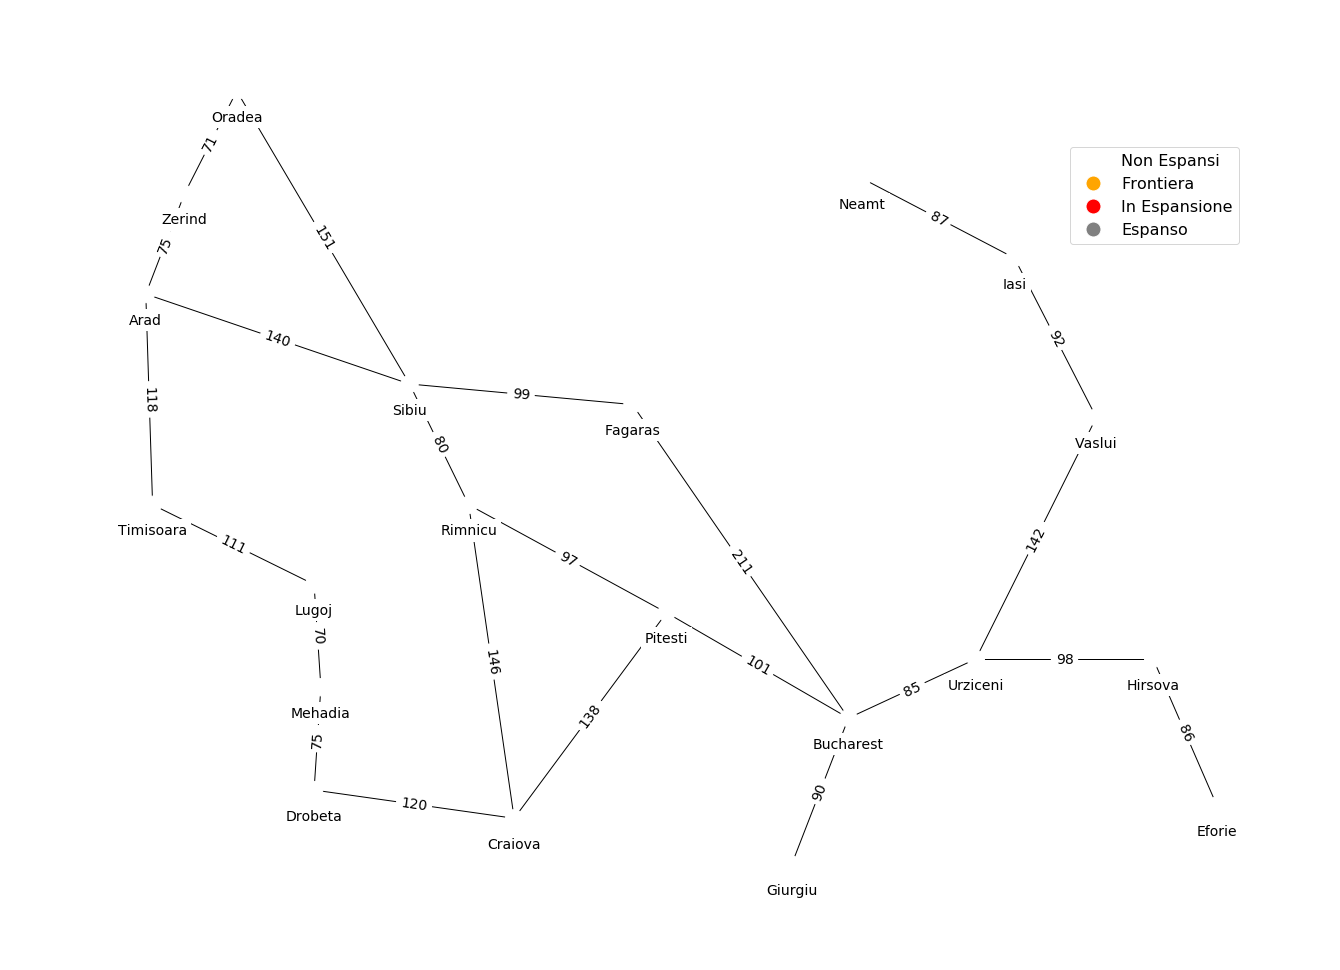

In [14]:
# Inizializza un grafo
G = nx.Graph()

# etichette
node_labels = dict()
#colori
node_colors = dict()

for n, p in romania_locations.items():
    # aggiunge nodi da romania_locations
    G.add_node(n)
    # etichette
    node_labels[n] = n
    # colori
    node_colors[n] = "white"

# salvo i nodi iniziali
initial_node_colors = dict(node_colors)
    
# posizioni delle etichette
node_label_pos = {k:[v[0],v[1]-10] for k,v in romania_locations.items()}

# etichette degli archi
edge_labels = dict()

# aggiunge i nodi della mappa della Romania sul grafo G
for node in romania_map.nodes():
    connections = romania_map.get(node)
    for connection in connections.keys():
        distance = connections[connection]
        # aggiunge i nodi al grafo
        G.add_edge(node, connection)
        # aggiunge le distanze alle etichette degli archi
        edge_labels[(node, connection)] = distance

def show_map(node_colors):
    # dimensione della figura
    plt.figure(figsize=(18,13))
    # disegna il grafo (sia nodi che archi)
    nx.draw(G, pos = romania_locations, node_color = [node_colors[node] for node in G.nodes()])

    # disegna le etichette
    node_label_handles = nx.draw_networkx_labels(G, pos = node_label_pos, labels = node_labels, font_size = 14)
    # aggiunge un bounding box bianco
    [label.set_bbox(dict(facecolor='white', edgecolor='none')) for label in node_label_handles.values()]

    # aggiunge le etichette agli archi del grafo
    nx.draw_networkx_edge_labels(G, pos = romania_locations, edge_labels=edge_labels, font_size = 14)
    
    # aggiunge la legenda
    white_circle = lines.Line2D([], [], color="white", marker='o', markersize=15, markerfacecolor="white")
    orange_circle = lines.Line2D([], [], color="white", marker='o', markersize=15, markerfacecolor="orange")
    red_circle = lines.Line2D([], [], color="white", marker='o', markersize=15, markerfacecolor="red")
    gray_circle = lines.Line2D([], [], color="white", marker='o', markersize=15, markerfacecolor="gray")
    plt.legend((white_circle, orange_circle, red_circle, gray_circle),
               ('Non Espansi', 'Frontiera', 'In Espansione', 'Espanso'),
               numpoints=1,prop={'size':16}, loc=(.8,.75))
    
    # mostra il grafico
    plt.show()

show_map(node_colors)

# Funzioni di supporto per la visualizzazione

In [15]:
def final_path_colors(problem, solution):   
    # colori iniziali
    final_colors = dict(initial_node_colors)
    # colora in verde tutti i nodi nella soluzione partendo dallo start
    final_colors[problem.initial] = "green"
    for node in solution:
        final_colors[node] = "green"  
    return final_colors

def display_visual(algorithm=None, problem=None):
        def slider_callback(iteration):
            # Non mostra il grafo alla prima iterazione
            try:
                show_map(all_node_colors[iteration])
            except:
                pass
        def visualize_callback(Visualize):
            if Visualize is True:
                button.value = False
                
                global all_node_colors
                
                iterations, all_node_colors, node = algorithm(problem)
                solution = node.solution()
                all_node_colors.append(final_path_colors(problem, solution))
                
                slider.max = len(all_node_colors) - 1
                
                for i in range(slider.max + 1):
                    slider.value = i
        
        slider = widgets.IntSlider(min=0, max=1, step=1, value=0)
        slider_visual = widgets.interactive(slider_callback, iteration = slider)
        display(slider_visual)

        button = widgets.ToggleButton(value = False)
        button_visual = widgets.interactive(visualize_callback, Visualize = button)
        display(button_visual)

# Tree Search

In [16]:
def tree_search(problem, frontier):   
    # usiamo due variabili per la visualizzazione del tempo
    iterations = 0
    all_node_colors = []
    node_colors = dict(initial_node_colors)
    
    frontier.append(s.Node(problem.initial))
    
    node_colors[s.Node(problem.initial).state] = "orange"
    iterations += 1
    all_node_colors.append(dict(node_colors))
    
    while frontier:
        node = frontier.pop()
        
        # modifica lo stato corrente in rosso
        node_colors[node.state] = "red"
        iterations += 1
        all_node_colors.append(dict(node_colors))
        
        if problem.goal_test(node.state):
            # modifica il nodo goal in verde dopo averlo raggiungo
            node_colors[node.state] = "green"
            iterations += 1
            all_node_colors.append(dict(node_colors))
            return(iterations, all_node_colors, node)
        
        frontier.extend(node.expand(problem))
           
        for n in node.expand(problem):
            node_colors[n.state] = "orange"
            iterations += 1
            all_node_colors.append(dict(node_colors))

        # modifica il colore del nodo esplorato in grigio
        node_colors[node.state] = "gray"
        iterations += 1
        all_node_colors.append(dict(node_colors))
        
    return None

def breadth_first_tree_search(problem):
    iterations, all_node_colors, node = tree_search(problem, s.FIFOQueue())
    return(iterations, all_node_colors, node)

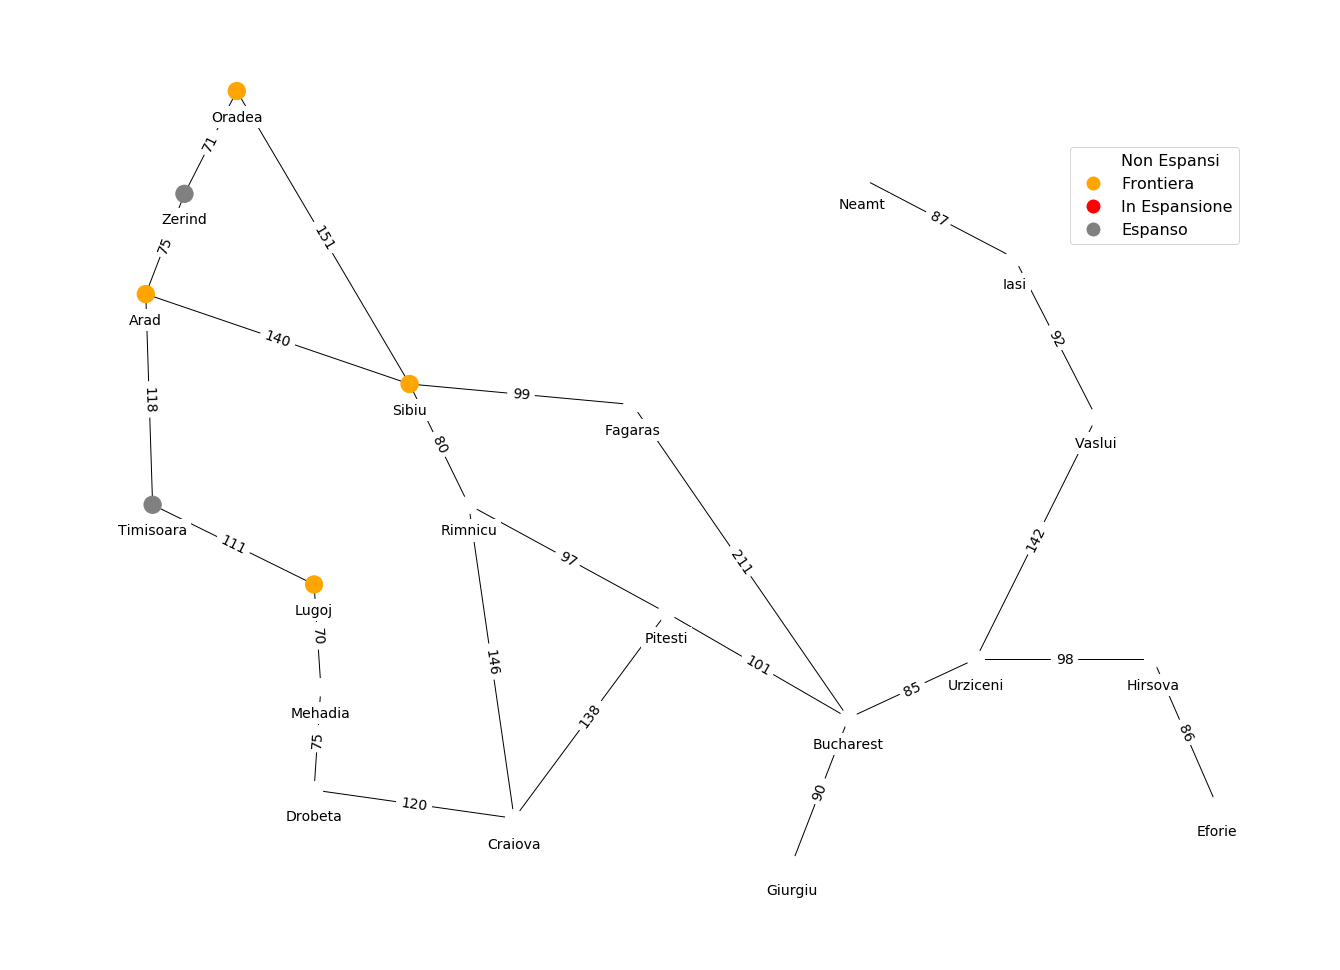

In [17]:
all_node_colors = []
romania_problem = s.GraphProblem('Arad', 'Fagaras', romania_map)
display_visual(algorithm = breadth_first_tree_search, problem = romania_problem)

# Ricerca in Ampiezza

In [18]:
def breadth_first_search(problem):   
    # usiamo due variabili per la visualizzazione del tempo
    iterations = 0
    all_node_colors = []
    node_colors = dict(initial_node_colors)
    
    node = s.Node(problem.initial)
    
    node_colors[node.state] = "red"
    iterations += 1
    all_node_colors.append(dict(node_colors))
      
    if problem.goal_test(node.state):
        node_colors[node.state] = "green"
        iterations += 1
        all_node_colors.append(dict(node_colors))
        return(iterations, all_node_colors, node)
    
    frontier = s.FIFOQueue()
    frontier.append(node)
    
    # modifica il colore dei nodi di frontiera in blu
    node_colors[node.state] = "orange"
    iterations += 1
    all_node_colors.append(dict(node_colors))
        
    explored = set()
    while frontier:
        node = frontier.pop()
        node_colors[node.state] = "red"
        iterations += 1
        all_node_colors.append(dict(node_colors))
        
        explored.add(node.state)     
        
        for child in node.expand(problem):
            if child.state not in explored and child not in frontier:
                if problem.goal_test(child.state):
                    node_colors[child.state] = "green"
                    iterations += 1
                    all_node_colors.append(dict(node_colors))
                    return(iterations, all_node_colors, child)
                frontier.append(child)

                node_colors[child.state] = "orange"
                iterations += 1
                all_node_colors.append(dict(node_colors))
                    
        node_colors[node.state] = "gray"
        iterations += 1
        all_node_colors.append(dict(node_colors))
    return None

In [19]:
all_node_colors = []
romania_problem = s.GraphProblem('Arad', 'Neamt', romania_map)
display_visual(algorithm = breadth_first_search, problem = romania_problem)

In [20]:
def best_first_graph_search(problem):
    iterations = 0
    all_node_colors = []
    node_colors = dict(initial_node_colors)

    node = s.Node(problem.initial)
    
    node_colors[node.state] = "red"
    iterations += 1
    all_node_colors.append(dict(node_colors))
    
    if problem.goal_test(node.state):
        node_colors[node.state] = "green"
        iterations += 1
        all_node_colors.append(dict(node_colors))
        return(iterations, all_node_colors, node)
    
    frontier = s.PriorityQueue(min)
    frontier.append(node)
    
    node_colors[node.state] = "orange"
    iterations += 1
    all_node_colors.append(dict(node_colors))
    
    explored = set()
    while frontier:
        node = frontier.pop()
        
        node_colors[node.state] = "red"
        iterations += 1
        all_node_colors.append(dict(node_colors))
        
        if problem.goal_test(node.state):
            node_colors[node.state] = "green"
            iterations += 1
            all_node_colors.append(dict(node_colors))
            return(iterations, all_node_colors, node)
        
        explored.add(node.state)
        for child in node.expand(problem):
            if child.state not in explored and child not in frontier:
                frontier.append(child)
                node_colors[child.state] = "orange"
                iterations += 1
                all_node_colors.append(dict(node_colors))
            elif child in frontier:
                incumbent = frontier[child]
                if (child < incumbent):
                    del frontier[incumbent]
                    frontier.append(child)
                    node_colors[child.state] = "orange"
                    iterations += 1
                    all_node_colors.append(dict(node_colors))

        node_colors[node.state] = "gray"
        iterations += 1
        all_node_colors.append(dict(node_colors))
    return None

def uniform_cost_search(problem):
    iterations, all_node_colors, node = best_first_graph_search(problem)
    return(iterations, all_node_colors, node)

In [21]:
all_node_colors = []
romania_problem = s.GraphProblem('Arad', 'Neamt', romania_map)
display_visual(algorithm = uniform_cost_search, problem = romania_problem)

In [22]:
from functools import wraps

def memo(func):
    cache = {}
    @wraps(func)
    def wrap(*args):
        if args not in cache:
            cache[args] = func(*args)
        return cache[args]
    return wrap

def best_first_graph_search(problem, f):
    """Search the nodes with the lowest f scores first.
    You specify the function f(node) that you want to minimize; for example,
    if f is a heuristic estimate to the goal, then we have greedy best
    first search; if f is node.depth then we have breadth-first search.
    There is a subtlety: the line "f = memoize(f, 'f')" means that the f
    values will be cached on the nodes as they are computed. So after doing
    a best first search you can examine the f values of the path returned."""
    
    # we use these two variables at the time of visualisations
    iterations = 0
    all_node_colors = []
    node_colors = dict(initial_node_colors)
    
    f = memo(f)
    node = s.Node(problem.initial)
    
    node_colors[node.state] = "red"
    iterations += 1
    all_node_colors.append(dict(node_colors))
    
    if problem.goal_test(node.state):
        node_colors[node.state] = "green"
        iterations += 1
        all_node_colors.append(dict(node_colors))
        return(iterations, all_node_colors, node)
    
    frontier = s.PriorityQueue(min, f)
    frontier.append(node)
    
    node_colors[node.state] = "orange"
    iterations += 1
    all_node_colors.append(dict(node_colors))
    
    explored = set()
    while frontier:
        node = frontier.pop()
        
        node_colors[node.state] = "red"
        iterations += 1
        all_node_colors.append(dict(node_colors))
        
        if problem.goal_test(node.state):
            node_colors[node.state] = "green"
            iterations += 1
            all_node_colors.append(dict(node_colors))
            return(iterations, all_node_colors, node)
        
        explored.add(node.state)
        for child in node.expand(problem):
            if child.state not in explored and child not in frontier:
                frontier.append(child)
                node_colors[child.state] = "orange"
                iterations += 1
                all_node_colors.append(dict(node_colors))
            elif child in frontier:
                incumbent = frontier[child]
                if f(child) < f(incumbent):
                    del frontier[incumbent]
                    frontier.append(child)
                    node_colors[child.state] = "orange"
                    iterations += 1
                    all_node_colors.append(dict(node_colors))

        node_colors[node.state] = "gray"
        iterations += 1
        all_node_colors.append(dict(node_colors))
    return None

def astar_search(problem, h=None):
    """A* search is best-first graph search with f(n) = g(n)+h(n).
    You need to specify the h function when you call astar_search, or
    else in your Problem subclass."""
    h = memo(h or problem.h)
    iterations, all_node_colors, node = best_first_graph_search(problem, lambda n: n.path_cost + h(n))
    return(iterations, all_node_colors, node)

all_node_colors = []
romania_problem = s.GraphProblem('Arad', 'Bucharest', romania_map)
display_visual(algorithm = astar_search, problem = romania_problem)